In [1]:
import matplotlib.pyplot as plot
import geopandas as gpd
import earthpy as et
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [2]:
data = pd.read_csv("datasets/1976-2018-house2.csv", encoding="latin1")

In [3]:
# First 5 rows
data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


# Vote Counts: Columns

year: year in which election was held

state: state name

description: state abbreviation

state_fips: numeric state code

state_cen: US census state code

state_ic: ICPSR state code

office: U.S. House (constant)

district: District number. At-large districts are coded as 0

stage: electoral stage ("gen" = general, "pri" = primary)

special: special election boolean (True = special election, False = regular election

candidate: name of candidate

party: party of candidate 

writein: boolean write in candidate (true = write-in, false = not write-in)

mode: mode of voting

candidatevotes: # of votes received by this candidate for this party

totalvates: total number of votes cast for this election

unofficial: boolean True/False (true = unofficial result)

version: date when this dataset was finalized

# Data Wrangling and Cleaning

Because we needed to work with vote counts by both state and district, we had to get our data into a form that would make it easy for us to work with. We began with the raw dataframe, which includes total votes for individual candidates by district. We also began with vote returns for all years. We decided to focus only on 2018, so we slices the data down to vote counts per districts, determined winners for districts and inserted those into columns, and dropped null values. We organized vote returns by district, by state, in a 2 dimensional dataframe. We also created a second dataframe for vote returns by state, which is simple the vote counts by district and state aggregated into vote counts by state--i.e. a rollup operation performed on district to aggregate votes by state.


Furthermore, we placed our gerrymandering metrics per state values as columns in a new dataframe.


In [4]:
# Define helper functions to slice and clean the data



# Group by district and list total democrat and republican votes.
# This gives us a dataframe of vote counts grouped by district.
def groupDistricts(df, party):
    party_votes = df.loc[df["party"] == party]
    party_votes = party_votes.loc[:, ["state", "district", "candidatevotes", "year"]]
    party_votes = party_votes.groupby(by=["year", "state", "district"]).sum()
    return party_votes

def get_vote_counts_bystate(df, year):
    data_year = data[data["year"] == year]
    data_year = data_year[["party", "state", "candidatevotes"]]
    
    demOnly = np.array(data_year["party"] == "democrat")
    repOnly = np.array(data_year["party"] == "republican")
    demVotes = data_year[demOnly].groupby(["state"]).sum()
    repVotes = data_year[repOnly].groupby(["state"]).sum()
    
    # Rename columns to get ready to join our dataframes.
    demVotes = demVotes.rename(columns={"candidatevotes": "dem_votes"})
    repVotes = repVotes.rename(columns={"candidatevotes": "rep_votes"})
    
    # Join on all states that have votes by both parties.
    vote_counts_bystate = demVotes.join(repVotes, how="inner")
    return vote_counts_bystate


def get_vote_counts_bydistrict(df):
    dem_votes = groupDistricts(df, "democrat")
    rep_votes = groupDistricts(df, "republican")
    dem_votes = dem_votes.rename(columns={"candidatevotes": "dem_votes"})
    rep_votes = rep_votes.rename(columns={"candidatevotes": "rep_votes"})
    
    # Outer join filters out na values
    vote_counts_bydistrict = dem_votes.join(rep_votes, how="outer")
    
    # Come up with the winners for each district.
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["dem_votes"] >= vote_counts_bydistrict["rep_votes"]
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["winner"].apply(lambda win_bool: "d" if win_bool else "r")

    # Some races had no democrat or republican candidate.
    # These can be seen in NaN columns.
    # Drop these.
    vote_counts_bydistrict = vote_counts_bydistrict.dropna()

    # Come up with the winners for the above dataframe.
    # Come up with the winners for the above dataframe.
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["dem_votes"] >= vote_counts_bydistrict["rep_votes"]
    vote_counts_bydistrict["winner"] = vote_counts_bydistrict["winner"].apply(lambda win_bool: "d" if win_bool else "r")
    
    return vote_counts_bydistrict



### Producing Sliced Dataframes

We can produce sliced and organized dataframes using our helper functions. We produce two dataframes: one for vote counts by state, and one for vote counts by district.


In [5]:
vote_counts_bydistrict = get_vote_counts_bydistrict(data)

In [6]:
num_districts = vote_counts_bydistrict.groupby(["year", "state"]).count().iloc[:,0]
vote_counts_bystate = vote_counts_bydistrict.groupby(["year", "state"]).sum()
vote_counts_bystate["num_districts"] = num_districts

In [7]:
# Cleaned data by district
vote_counts_bydistrict

dem_votes  rep_votes winner
year state     district                             
1976 Alabama   1           58906.0    98257.0      r
               2           66288.0    90069.0      r
               4          141490.0    34531.0      d
               6           69384.0    92113.0      r
     Alaska    0           34194.0    83722.0      r
...                            ...        ...    ...
2018 Wisconsin 5          138385.0   225619.0      r
               6          144536.0   180311.0      r
               7          124307.0   194061.0      r
               8          119265.0   209410.0      r
     Wyoming   0           59903.0   127963.0      r

[8173 rows x 3 columns]

In [8]:
# Cleaned data by state
vote_counts_bystate

dem_votes  rep_votes  num_districts
year state                                             
1976 Alabama         336068.0   314970.0              4
     Alaska           34194.0    83722.0              1
     Arizona         355747.0   340478.0              4
     Arkansas        260997.0    75384.0              2
     California     4061169.0  3220418.0             42
...                       ...        ...            ...
2018 Virginia       1668446.0  1408701.0             10
     Washington     1437839.0  1048712.0              8
     West Virginia   234568.0   337146.0              3
     Wisconsin      1058376.0  1172964.0              7
     Wyoming          59903.0   127963.0              1

[1074 rows x 3 columns]

# Calculating Efficiency Gap

In [9]:

def wasted_winner(total_votes_winner, district_vote_total):
    # Votes needed to win: 1 + (total votes / 2) 
    votes_needed = (district_vote_total / 2) + 1
    return total_votes_winner - (votes_needed)

def get_efficiency_gap(dem_votes, rep_votes, wasted_dem, wasted_rep):
    return (wasted_dem - wasted_rep) / (dem_votes + rep_votes)

def calculate_wasted_votes(df_district):
    """
        Takes the "by district"
        dataframe, calculates efficiency gap,
        places it into a column in the "by state"
    """
    dem_votes = np.array(df_district["dem_votes"])
    rep_votes = np.array(df_district["rep_votes"])
    rep_winner = np.array(df_district["dem_votes"] < df_district["rep_votes"])
    total_votes = dem_votes + rep_votes
    wasted_votes_dem = np.zeros(len(rep_winner))
    wasted_votes_rep = np.zeros(len(rep_winner))
    for i in range(len(rep_winner)):
        if rep_winner[i]:
            wasted_votes_rep[i] = wasted_winner(rep_votes[i], total_votes[i])
            wasted_votes_dem[i] = dem_votes[i]
        else:
            wasted_votes_dem[i] = wasted_winner(dem_votes[i], total_votes[i])
            wasted_votes_rep[i] = rep_votes[i]
    return wasted_votes_rep, wasted_votes_dem



In [10]:
vote_counts_bydistrict

dem_votes  rep_votes winner
year state     district                             
1976 Alabama   1           58906.0    98257.0      r
               2           66288.0    90069.0      r
               4          141490.0    34531.0      d
               6           69384.0    92113.0      r
     Alaska    0           34194.0    83722.0      r
...                            ...        ...    ...
2018 Wisconsin 5          138385.0   225619.0      r
               6          144536.0   180311.0      r
               7          124307.0   194061.0      r
               8          119265.0   209410.0      r
     Wyoming   0           59903.0   127963.0      r

[8173 rows x 3 columns]

In [11]:
# Calculate wasted votes by district
wasted_rep_district, wasted_dem_district = calculate_wasted_votes(vote_counts_bydistrict)
vote_counts_bydistrict["wasted_democrat"] = wasted_dem_district
vote_counts_bydistrict["wasted_republican"] = wasted_rep_district

# Group wasted votes by state
vote_counts_bystate["wasted_democrat"] = vote_counts_bydistrict["wasted_democrat"].groupby(["year", "state"]).sum()
vote_counts_bystate["wasted_republican"] = vote_counts_bydistrict["wasted_republican"].groupby(["year", "state"]).sum()

# Gather variables to calculate efficiency gap
wasted_democrat = vote_counts_bystate["wasted_democrat"] 
wasted_republican = vote_counts_bystate["wasted_republican"]
dem_votes = vote_counts_bystate["dem_votes"]
rep_votes = vote_counts_bystate["rep_votes"]

# Calculate efficiency gap
vote_counts_bystate["e_gap"] = get_efficiency_gap(dem_votes, rep_votes, wasted_democrat, wasted_republican)

In [12]:
vote_counts_bystate

dem_votes  rep_votes  num_districts  wasted_democrat  \
year state                                                                 
1976 Alabama         336068.0   314970.0              4         248056.5   
     Alaska           34194.0    83722.0              1          34194.0   
     Arizona         355747.0   340478.0              4         182827.5   
     Arkansas        260997.0    75384.0              2          92804.5   
     California     4061169.0  3220418.0             42        1841126.5   
...                       ...        ...            ...              ...   
2018 Virginia       1668446.0  1408701.0             10         714841.0   
     Washington     1437839.0  1048712.0              8         621013.0   
     West Virginia   234568.0   337146.0              3         234568.0   
     Wisconsin      1058376.0  1172964.0              7         768151.0   
     Wyoming          59903.0   127963.0              1          59903.0   

                    wasted_republican     e_gap  
year state                                       
1976 Alabama                  77458.5  0.262040  
     Alaska                   24763.0  0.079981  
     Arizona                 165281.0  0.025202  
     Arkansas                 75384.0  0.051788  
     California             1799625.0  0.005700  
...                               ...       ...  
2018 Virginia                823722.5 -0.035384  
     Washington              622254.5 -0.000499  
     West Virginia            51286.0  0.320583  
     Wisconsin               347512.0  0.188514  
     Wyoming                  34029.0  0.137726  

[1074 rows x 6 columns]

In [13]:
vote_counts_bydistrict

dem_votes  rep_votes winner  wasted_democrat  \
year state     district                                                 
1976 Alabama   1           58906.0    98257.0      r          58906.0   
               2           66288.0    90069.0      r          66288.0   
               4          141490.0    34531.0      d          53478.5   
               6           69384.0    92113.0      r          69384.0   
     Alaska    0           34194.0    83722.0      r          34194.0   
...                            ...        ...    ...              ...   
2018 Wisconsin 5          138385.0   225619.0      r         138385.0   
               6          144536.0   180311.0      r         144536.0   
               7          124307.0   194061.0      r         124307.0   
               8          119265.0   209410.0      r         119265.0   
     Wyoming   0           59903.0   127963.0      r          59903.0   

                         wasted_republican  
year state     district                     
1976 Alabama   1                   19674.5  
               2                   11889.5  
               4                   34531.0  
               6                   11363.5  
     Alaska    0                   24763.0  
...                                    ...  
2018 Wisconsin 5                   43616.0  
               6                   17886.5  
               7                   34876.0  
               8                   45071.5  
     Wyoming   0                   34029.0  

[8173 rows x 5 columns]

## Calculating Mean-Median Difference

In [14]:
def get_mm(dem_votes_district, rep_votes_district):
    # This cell performs the calculation of mean-median difference.
    total_votes = dem_votes_district + rep_votes_district
    dem_voteshare = dem_votes_district / total_votes
    rep_voteshare = rep_votes_district / total_votes

    total_dem_voteshare = np.sum(dem_voteshare)
    total_districts = len(dem_voteshare)
    dem_district_median = np.median(dem_voteshare)
    dem_mean_share = total_dem_voteshare / total_districts

    total_rep_voteshare = np.sum(rep_voteshare)
    rep_district_median = np.median(rep_voteshare)
    rep_mean_share = total_rep_voteshare / total_districts

    mm_diff_against_dem = dem_mean_share - dem_district_median
    mm_diff_against_rep = rep_mean_share - rep_district_median

    return mm_diff_against_dem, mm_diff_against_rep


In [15]:
mm_diff_against_dem = []
mm_diff_against_rep = []
for year, state in vote_counts_bystate.index:
    dem_votes = vote_counts_bydistrict.loc[year, state]["dem_votes"]
    rep_votes = vote_counts_bydistrict.loc[year, state]["rep_votes"]
    current_mm_diff_against_dem, current_mm_diff_against_rep = get_mm(dem_votes, rep_votes)
    mm_diff_against_dem.append(current_mm_diff_against_dem)
    mm_diff_against_rep.append(current_mm_diff_against_rep)
    
vote_counts_bystate["mm_diff_against_dem"] = mm_diff_against_dem
vote_counts_bystate["mm_diff_against_rep"] = mm_diff_against_rep

## Calculating Partisan Bias

In [16]:
def get_pb(dem_votes, rep_votes):
    # Takes arrays of votes per district
    dem_votes_total = np.sum(dem_votes)
    rep_votes_total = np.sum(rep_votes)
    num_districts = len(dem_votes)
    vote_total_state = np.sum([dem_votes, rep_votes])
    dem_votes_tied = dem_votes - (get_vote_diff(vote_total_state, dem_votes_total, .5, num_districts)) 
    rep_votes_tied = rep_votes - (get_vote_diff(vote_total_state,  rep_votes_total, .5, num_districts))
    rep_won_districts = np.sum(np.greater(rep_votes_tied, dem_votes_tied))
    dem_won_districts = np.sum(np.greater(dem_votes_tied, rep_votes_tied))
    rep_won_percent = rep_won_districts / num_districts
    dem_won_percent = dem_won_districts / num_districts
    partisan_bias_against_dem = rep_won_percent - 0.5
    partisan_bias_against_rep = dem_won_percent - 0.5
    return partisan_bias_against_dem, partisan_bias_against_rep



In [17]:
# First get the total vote difference.
# This number represents the number of votes above 50% a party received in a state.
def get_vote_diff(total_votes, total_votes_party, target_percent, districts):
    return ((total_votes_party / total_votes) - target_percent) * total_votes / districts

In [18]:
pb_against_dem = []
pb_against_rep = []
for year, state in vote_counts_bystate.index:
    dem_votes = vote_counts_bydistrict.loc[year, state]["dem_votes"]
    rep_votes = vote_counts_bydistrict.loc[year, state]["rep_votes"]
    partisan_bias_against_dem, partisan_bias_against_rep = get_pb(dem_votes, rep_votes)
    pb_against_dem.append(partisan_bias_against_dem)
    pb_against_rep.append(partisan_bias_against_rep)
vote_counts_bystate["partisan_bias_against_dem"] = pb_against_dem
vote_counts_bystate["partisan_bias_against_rep"] = pb_against_rep
    

In [19]:
vote_counts_bystate

dem_votes  rep_votes  num_districts  wasted_democrat  \
year state                                                                 
1976 Alabama         336068.0   314970.0              4         248056.5   
     Alaska           34194.0    83722.0              1          34194.0   
     Arizona         355747.0   340478.0              4         182827.5   
     Arkansas        260997.0    75384.0              2          92804.5   
     California     4061169.0  3220418.0             42        1841126.5   
...                       ...        ...            ...              ...   
2018 Virginia       1668446.0  1408701.0             10         714841.0   
     Washington     1437839.0  1048712.0              8         621013.0   
     West Virginia   234568.0   337146.0              3         234568.0   
     Wisconsin      1058376.0  1172964.0              7         768151.0   
     Wyoming          59903.0   127963.0              1          59903.0   

                    wasted_republican     e_gap  mm_diff_against_dem  \
year state                                                             
1976 Alabama                  77458.5  0.262040             0.081262   
     Alaska                   24763.0  0.079981             0.000000   
     Arizona                 165281.0  0.025202            -0.003855   
     Arkansas                 75384.0  0.051788             0.000000   
     California             1799625.0  0.005700            -0.054207   
...                               ...       ...                  ...   
2018 Virginia                823722.5 -0.035384             0.026638   
     Washington              622254.5 -0.000499             0.004619   
     West Virginia            51286.0  0.320583            -0.024979   
     Wisconsin               347512.0  0.188514             0.047635   
     Wyoming                  34029.0  0.137726             0.000000   

                    mm_diff_against_rep  partisan_bias_against_dem  \
year state                                                           
1976 Alabama                  -0.081262                   0.250000   
     Alaska                    0.000000                  -0.500000   
     Arizona                   0.003855                   0.000000   
     Arkansas                  0.000000                   0.000000   
     California                0.054207                  -0.071429   
...                                 ...                        ...   
2018 Virginia                 -0.026638                   0.100000   
     Washington               -0.004619                   0.000000   
     West Virginia             0.024979                  -0.166667   
     Wisconsin                -0.047635                   0.214286   
     Wyoming                   0.000000                  -0.500000   

                    partisan_bias_against_rep  
year state                                     
1976 Alabama                        -0.250000  
     Alaska                         -0.500000  
     Arizona                         0.000000  
     Arkansas                        0.000000  
     California                      0.071429  
...                                       ...  
2018 Virginia                       -0.100000  
     Washington                      0.000000  
     West Virginia                   0.166667  
     Wisconsin                      -0.214286  
     Wyoming                        -0.500000  

[1074 rows x 10 columns]

# Simulating Gerrymandering Metric Distributions


In [20]:
import random


def simulate_elections(num_districts, num_voters, num_simulations):
    e_gap_values = []
    mm_diff_against_dem = []
    mm_diff_against_rep = []
    pb_against_dem = []
    pb_against_rep = []
    
    for i in range(num_simulations):
        vote_counts_simulate = pd.DataFrame()
        total_votes = 10000
        
        # Random voting proportions per district
        random_district_proportions = []
        
        # Continually decrement proportions and
        # assign the last one to the last district
        remaining_proportion = 1 
        
        # Generate random voting proportions per district
        for i in range(len(vote_counts_simulate) - 1):
            random_sample = random.uniform(0, remaining_proportion)
            random_district_proportions.append(random_sample)
            remaining_proportion -= random_sample
        
        # Fill in the proportions list with proportions
        random_district_proportions.append(remaining_proportion)
        random_district_proportions = np.array(random_district_proportions)
        
        # District totals is the number of votes assigned to each district
        district_totals = total_votes * random_district_proportions
        random_democrat_proportion = []
        
        # Random democrat proportion is a random proportion of democrat votes per district
        for i in range(num_districts):
            random_democrat_proportion.append(random.uniform(0, 1))
            
        # Dem votes random is the number of democrat votes
        dem_votes_random = district_totals * random_democrat_proportion
        
        # Rep votes is the remaining proportion
        rep_votes_random = district_totals - dem_votes_random
        
        # Assign to a dataframe
        vote_counts_simulate["dem_votes"] = dem_votes_random
        vote_counts_simulate["rep_votes"] = rep_votes_random
        
        # Wasted votes for efficiency gap calculation
        wasted_dem_random, wasted_rep_random = calculate_wasted_votes(vote_counts_simulate)
        wasted_dem_state = np.sum(wasted_dem_random)
        wasted_rep_state = np.sum(wasted_rep_random)
        
        # Vote totals for the state
        dem_state_votes = np.sum(dem_votes_random)
        rep_state_votes = np.sum(rep_votes_random)
        
        # Calculate the metrics
        e_gap = get_efficiency_gap(dem_state_votes, rep_state_votes, wasted_dem_state, wasted_rep_state)
        mm_single_dem, mm_single_rep = get_mm(dem_votes_random, rep_votes_random)
        pb_against_dem_state, pb_against_rep_state = get_pb(dem_votes_random, rep_votes_random)
        pb_against_dem.append(pb_against_dem_state)
        pb_against_rep.append(pb_against_rep_state)
        mm_diff_against_dem.append(mm_single_dem)
        mm_diff_against_rep.append(mm_single_rep)
        e_gap_values.append(e_gap)
        
    return e_gap_values, mm_diff_against_dem, mm_diff_against_rep, pb_against_dem, pb_against_rep

# Store in variables for use in this notebook
e_gap_values, mm_diff_against_dem_sim,  mm_diff_against_rep_sim, pb_against_dem, pb_against_rep = simulate_elections(50, 10000000, 10000)

## KDE For Efficiency Gap For All States
Estimates the underlying distribution.

Our efficiency gap calculation is performed by counting the wasted democrat and wasted republican votes.

A vote is considered wasted if:

a) The vote was for a losing candidate in a district.

b) The vote for a winning candidate was beyond the threshold needed for that candidate to win, i.e. beyond 1 + (TotalVotes / 2)


Our efficiency gap formula used to make our calculation is as follows:

(dem_wasted_votes - rep_wasted_votes) / total_votes

This means that a positive value indicates more Democrat wasted votes, which indicates a gerrymander in favor of the Republican party. Likewise, a negative value indicates more Republican wasted votes and a gerrymander in favor of the Democratic party.

The efficiency gap distribution across the country has a slight negative skew, which indicates a slight Republican gerrymander across the US according to this metric.

The middle line is the mean, and the top and bottom lines are -1 and +1 stds from the mean respectively. This tells us which states our efficiency gap considers to be gerrymandered in a hypothesis test with a 68% confidence interval.



C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


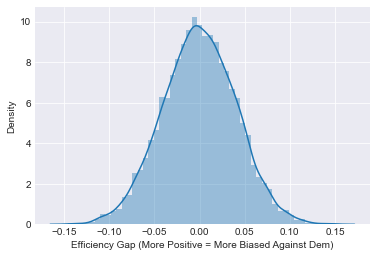

In [21]:
_ = sns.distplot(e_gap_values, axlabel="Efficiency Gap (More Positive = More Biased Against Dem)")


C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


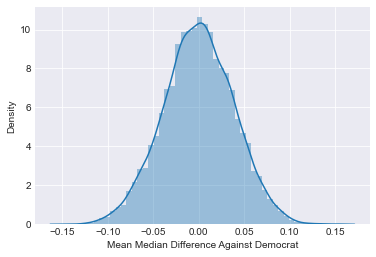

In [22]:
_ = sns.distplot(mm_diff_against_dem_sim, axlabel="Mean Median Difference Against Democrat")

C:\Users\dpale\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


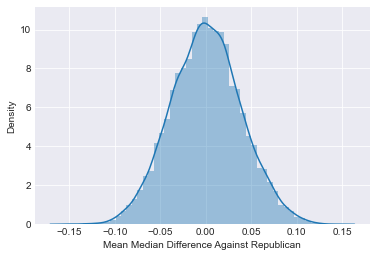

In [23]:
_ = sns.distplot(mm_diff_against_rep_sim, axlabel="Mean Median Difference Against Republican")

[Text(0.5, 0, 'Partisan Bias Against Democrat')]

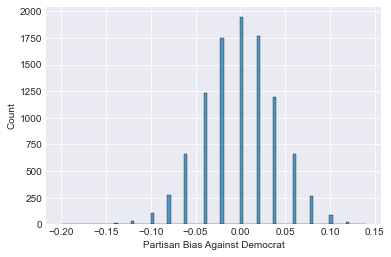

In [24]:
ax = sns.histplot(pb_against_dem)
ax.set(xlabel="Partisan Bias Against Democrat")

[Text(0.5, 0, 'Partisan Bias Against Republican')]

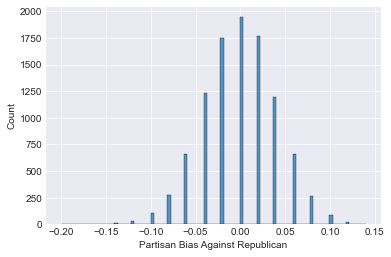

In [25]:
ax = sns.histplot(pb_against_dem, label="Partisan Bias Against Republican")
ax.set(xlabel="Partisan Bias Against Republican")

Text(0.5, 1.0, 'Gerrymandering Mean Distribution (50 Districts, 10M voters)')

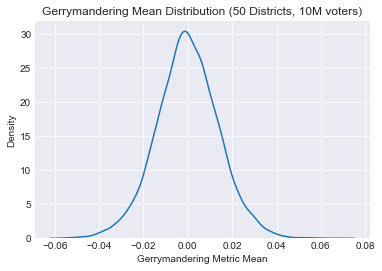

In [26]:
mean_of_metrics = np.mean([e_gap_values, pb_against_dem, mm_diff_against_rep_sim], axis=0)
ax = sns.kdeplot(mean_of_metrics)
ax.set(xlabel="Gerrymandering Metric Mean")
plt.title('Gerrymandering Mean Distribution (50 Districts, 10M voters)')

In [27]:
# Get efficiency gap means and stds for election simulations
# for states between 3 and 60 districts
e_gap_std = []
e_gap_mean = []
mm_diff_std_dem = []
mm_diff_mean_dem = []
pb_against_dem_std = []
pb_against_dem_mean = []
aggregated_metrics_std = []
aggregated_metrics_mean = []

# Simulate elections for states with 3 districts, up to 60 districts
# Acquire means and stds for our metrics
for i in range(3, 60):
    e_gap_simulated, mm_diff_against_dem, mm_diff_against_rep, pb_dem, pb_rep = simulate_elections(i, 10000000, 1000)
    e_gap_std.append(np.std(e_gap_simulated))
    e_gap_mean.append(np.mean(e_gap_simulated))
    mm_diff_mean_dem.append(np.mean(mm_diff_against_dem))
    mm_diff_std_dem.append(np.std(mm_diff_against_dem))
    pb_against_dem_std.append(np.std(pb_dem))
    pb_against_dem_mean.append(np.mean(pb_dem))
    mean_of_metrics = np.mean([e_gap_simulated, mm_diff_against_dem, pb_dem], axis=0)
    aggregated_metrics_std.append(np.std(mean_of_metrics))
    aggregated_metrics_mean.append(np.mean(mean_of_metrics))


# Hypothesis Testing on Various Distributions - Efficiency Gap

After simulating ~1000 elections for district numbers ranging from 3 to 60, we can see that the number of districts affects the distribution of the efficiency gap. This can be seen by looking at the top, middle, and bottom lines on this chart. The x axis on this graph is the number of districts, and the y axis is the efficiency gap value. We can see that the distribution narrows as we increase the number of districts, so we take this into account when we compare a state's efficiency gap against the distribution in a hypothesis test.

The top line in this graph is  mean + 2 * std of the efficiency gap. The bottom line is mean - 2 * std, and the middle line is the mean which we can see consistently staying around 0.

A positive efficiency gap value in our calculation indicates a gerrymander against the democratic party, and a negative value indicates a gerrymander against the republican party.

By visually plotting efficiency gap values for each state, we visually see where the states fall on a hypothesis test with a significance level of 5%.

According to the efficiency gap, gerrymandered states against the democratic party in 2018 were Indiana, North Carolina, Ohio, and Texas. Gerrymandered states against the republican party in 2018 were Connecticut and New Jersey with California and Iowa sitting on the fringe.

In [28]:
# Calculate average of metrics
metrics = vote_counts_bystate.loc[:,["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem"]]
vote_counts_bystate["gerry_metrics_mean"] = metrics.mean(axis=1)

In [29]:
# Slice vote counts in 2018

# Count only states with more than 3 districts.
def over_3_districts(num_districts):
    if num_districts > 3:
        return True
    return False

vote_counts_bystate_2018 = vote_counts_bystate.loc[2018]
districts_over_3 = vote_counts_bystate_2018["num_districts"].apply(over_3_districts)
vote_counts_bystate_2018 = vote_counts_bystate_2018[districts_over_3]
vote_counts_bystate_2018 = vote_counts_bystate_2018.sort_values(by="num_districts")

Text(0.5, 1.0, 'Efficiency Gap State Scores And 95% Confidence Interval')

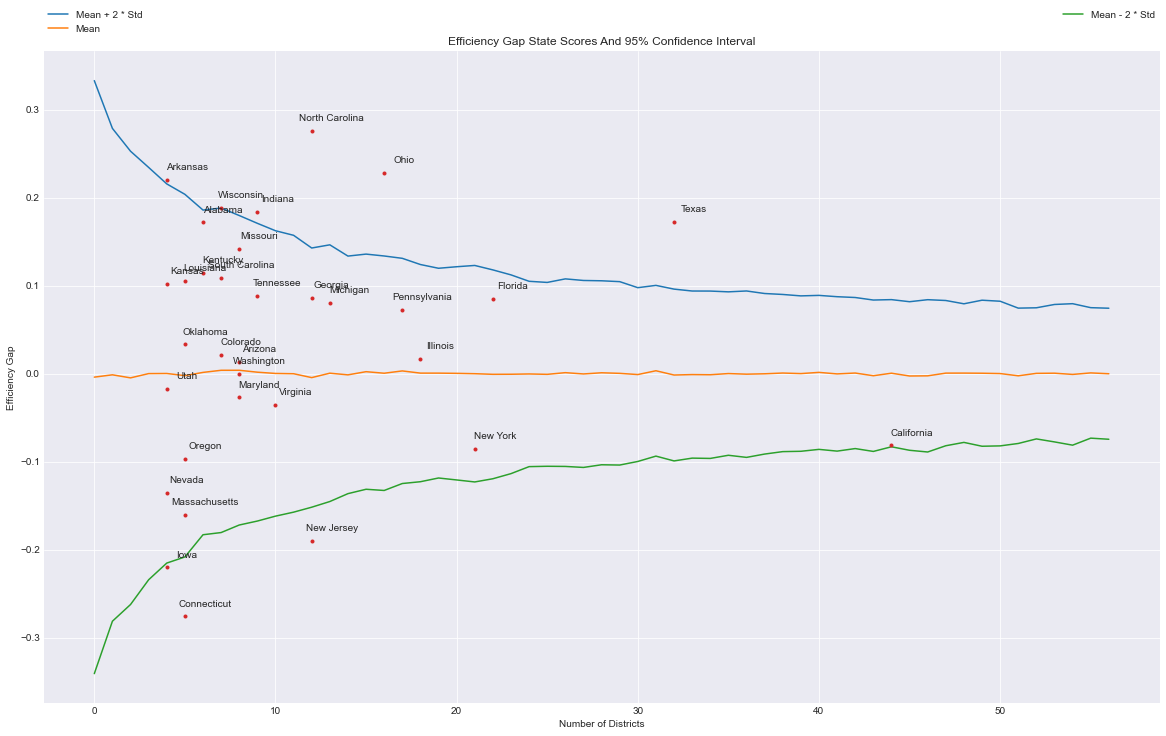

In [30]:
# Plot means and stds with increasing number of districts for efficiency gap
e_gap_mean = np.array(e_gap_mean)
e_gap_std = np.array(e_gap_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(e_gap_mean + 2 * e_gap_std, label="Mean + 2 * Std")
plt.plot(e_gap_mean, label="Mean")
plt.plot(e_gap_mean - 2 * e_gap_std, label="Mean - 2 * Std")
plt.plot(vote_counts_bystate_2018["num_districts"], vote_counts_bystate_2018["e_gap"],
         linestyle="none",
        marker=".")

for x, y, label in zip(vote_counts_bystate_2018["num_districts"], 
                       vote_counts_bystate_2018["e_gap"],
                        vote_counts_bystate_2018.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Efficiency Gap')
plt.title("Efficiency Gap State Scores And 95% Confidence Interval")



## Mean-Median Overview

The mean-median difference is a party’s median vote share minus its mean vote share, across all of a plan’s districts. For example, if a party has a median vote share of 45% and a mean vote share of 50%, then the plan has a mean-median difference of 5% against this party. When the mean and the median diverge significantly, the district distribution is skewed in favor of one party and against its opponent. Conversely, when the mean and the median are close, the district distribution is more symmetric.

Mean-Median difference essentially gives us a measure of skewness over a party's vote shares across its districts.

A large mean-median difference value for a party means that this party has a few districts that pull the mean away from the median. This is an indicator of packing, in which district lines pack voters of a party into a few districts to prevent them from winning races across the board in the state.

### Mean-Median Calculation

We derive two features from our vote count data to calculate the mean-median difference. These are labelled "dem_mm_diff" and "rep_mm_diff". This is done by first calculating the percent vote share for the two parties in their districts. For each state, we then average the vote shares for the two parties and get their medians. Finally, we difference the two (again, for each party) and this value is our mean-median difference value for the party.

A high dem_mm_diff value indicates that the democratic party is a victim of packing. Converesely, a high rep_mm_diff value indicates the same for the republican party.

Text(0.5, 1.0, 'Mean-Median Difference Scores and 95% Confidence Interval')

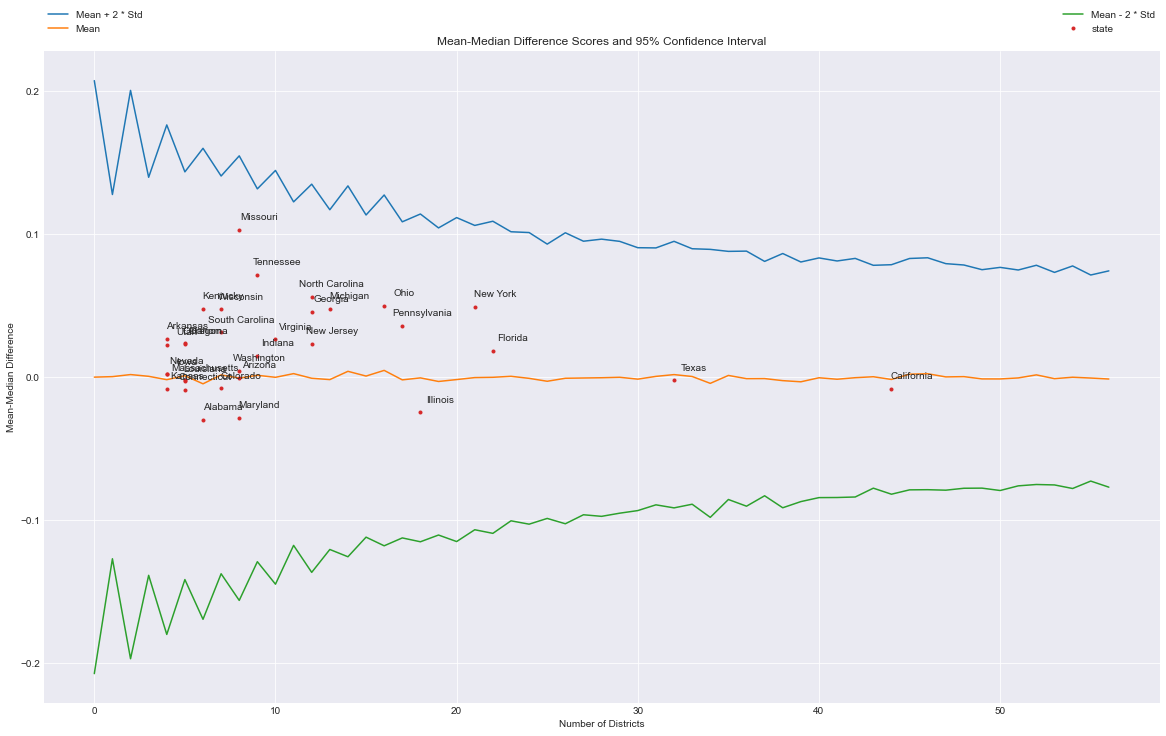

In [31]:
# Plot means and stds with increasing number of districts for mean/median difference
mm_diff_mean_dem = np.array(mm_diff_mean_dem)
mm_diff_std_dem = np.array(mm_diff_std_dem)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(mm_diff_mean_dem + 2 * mm_diff_std_dem, label="Mean + 2 * Std")
plt.plot(mm_diff_mean_dem, label="Mean")
plt.plot(mm_diff_mean_dem - 2 * mm_diff_std_dem, label="Mean - 2 * Std")


plt.plot(vote_counts_bystate_2018["num_districts"], vote_counts_bystate_2018["mm_diff_against_dem"],
         linestyle="none",
        marker=".", label="state")

for x, y, label in zip(vote_counts_bystate_2018["num_districts"], 
                       vote_counts_bystate_2018["mm_diff_against_dem"],
                        vote_counts_bystate_2018.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Mean-Median Difference')
plt.title("Mean-Median Difference Scores and 95% Confidence Interval")


# Partisan Bias

Partisan bias is another measure of gerrymandering. The partisan bias measurement uses the observed voting results and extrapolates them to create a hypothetical tied election. In this hypothetical tied election, we would expect both parties to receive 50% of congressional seats for their state. The partisan bias is the difference between the percentage of received seats by a party in this hypothetical election and 50%. A high value indicates that a party is receiving more seats than it "should" be given a tied election.

Text(0.5, 1.0, 'Partisan Bias 95% Confidence Interval and State Scores')

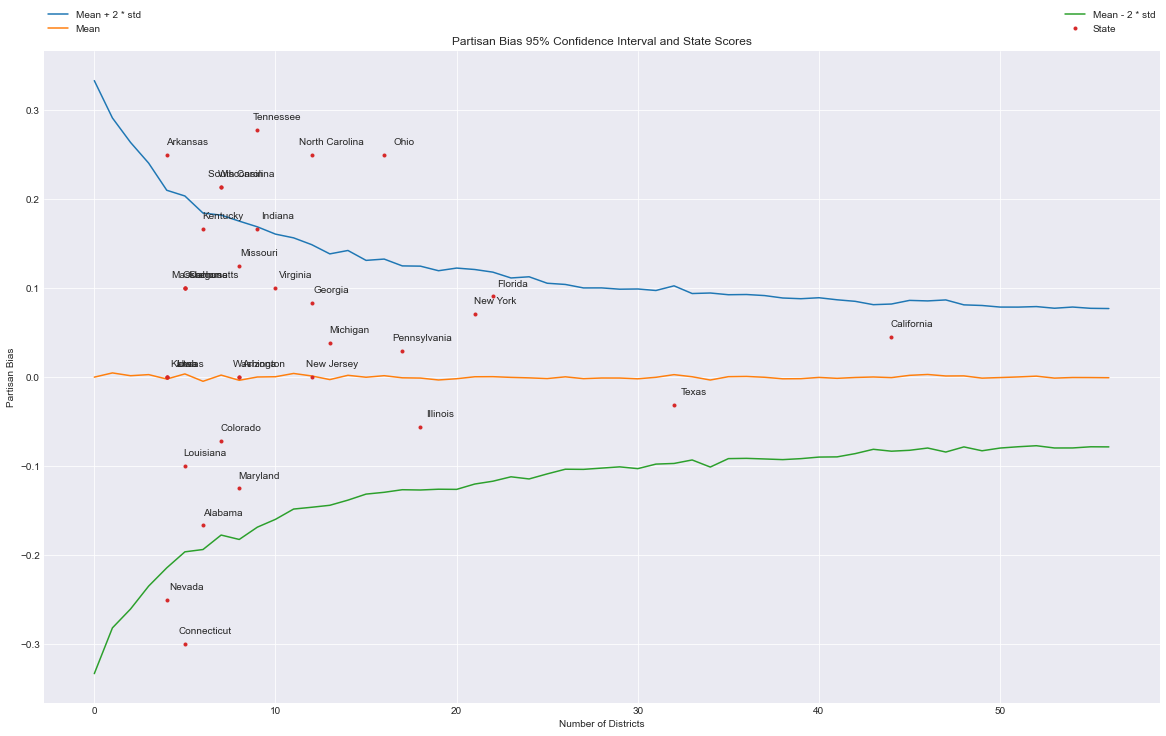

In [32]:
# Plot means and stds with increasing number of districts for mean/median difference
pb_against_dem_mean = np.array(pb_against_dem_mean)
pb_against_dem_std = np.array(pb_against_dem_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(pb_against_dem_mean + 2 * pb_against_dem_std, label="Mean + 2 * std")
plt.plot(pb_against_dem_mean, label="Mean")
plt.plot(pb_against_dem_mean - 2 * pb_against_dem_std, label="Mean - 2 * std")

plt.plot(vote_counts_bystate_2018["num_districts"], vote_counts_bystate_2018["partisan_bias_against_dem"],
         linestyle="none",
        marker=".", label="State")

for x, y, label in zip(vote_counts_bystate_2018["num_districts"], 
                       vote_counts_bystate_2018["partisan_bias_against_dem"],
                        vote_counts_bystate_2018.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Partisan Bias')
plt.title("Partisan Bias 95% Confidence Interval and State Scores")


Text(0.5, 1.0, 'Mean of Gerrymandering Scores and 95% Interval By Number of Districts (e_gap, mean median, partisan bias)')

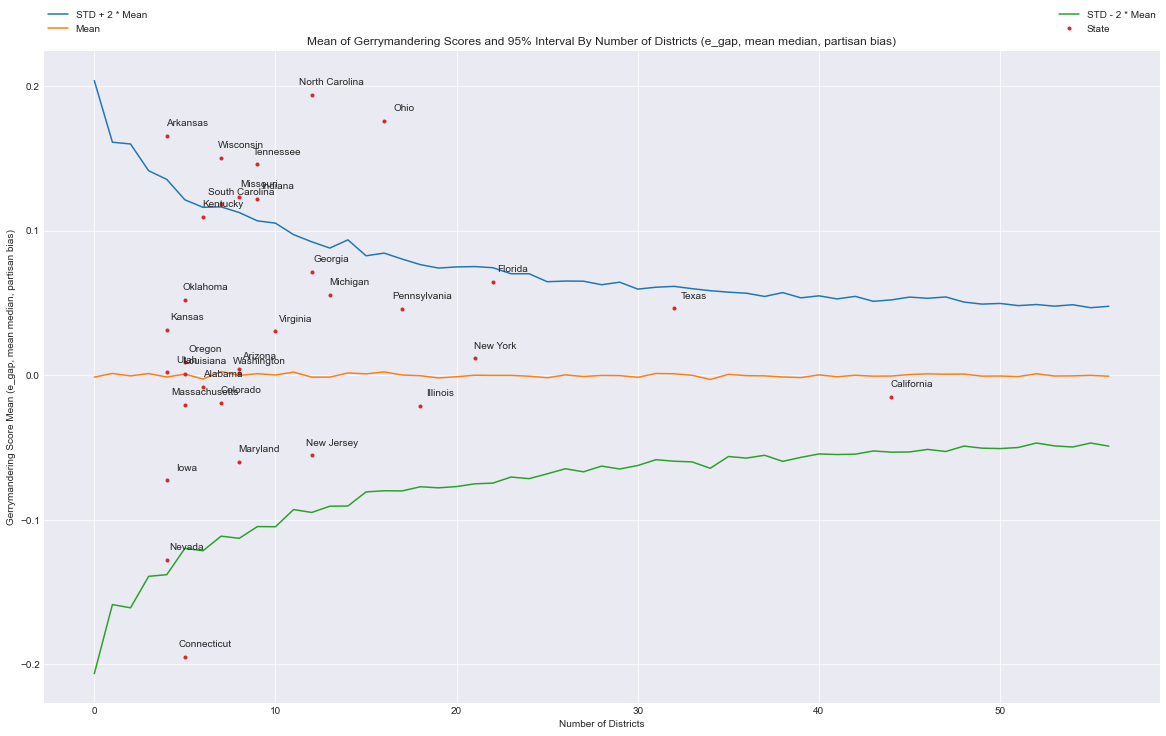

In [33]:
# Plot means and stds with increasing number of districts for mean/median difference
aggregated_metrics_mean = np.array(aggregated_metrics_mean)
aggregated_metrics_std = np.array(aggregated_metrics_std)

fig = plt.gcf()
fig.set_size_inches(20, 12)

plt.plot(aggregated_metrics_mean + 2 * aggregated_metrics_std, label="STD + 2 * Mean")
plt.plot(aggregated_metrics_mean, label="Mean")
plt.plot(aggregated_metrics_mean - 2 * aggregated_metrics_std, label="STD - 2 * Mean")

plt.plot(vote_counts_bystate_2018["num_districts"], vote_counts_bystate_2018["gerry_metrics_mean"],
         linestyle="none",
        marker=".", label="State")

for x, y, label in zip(vote_counts_bystate_2018["num_districts"], 
                       vote_counts_bystate_2018["gerry_metrics_mean"],
                        vote_counts_bystate_2018.index):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(20,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('Number of Districts')
plt.ylabel('Gerrymandering Score Mean (e_gap, mean median, partisan bias)')
plt.title("Mean of Gerrymandering Scores and 95% Interval By Number of Districts (e_gap, mean median, partisan bias)")


## Examining Correlations

By looking at pairplots and correlations plots, we can see that our gerrymandering metrics are all postiively correlated. First we look at all metrics for and against both parties, and we see that a gerrymander against one party is negatively correlated with a gerrymander for another.

Since the gerrymandering metrics mirror each other--e.g. the gerrymandering score for one party exactly matchins the negative for another on a given state, we look at metrics that measure gerrymandering against democrat voters with the understanding that a positive value means a gerrymander against democrats, and a negative value means a gerrymander against republicans. 


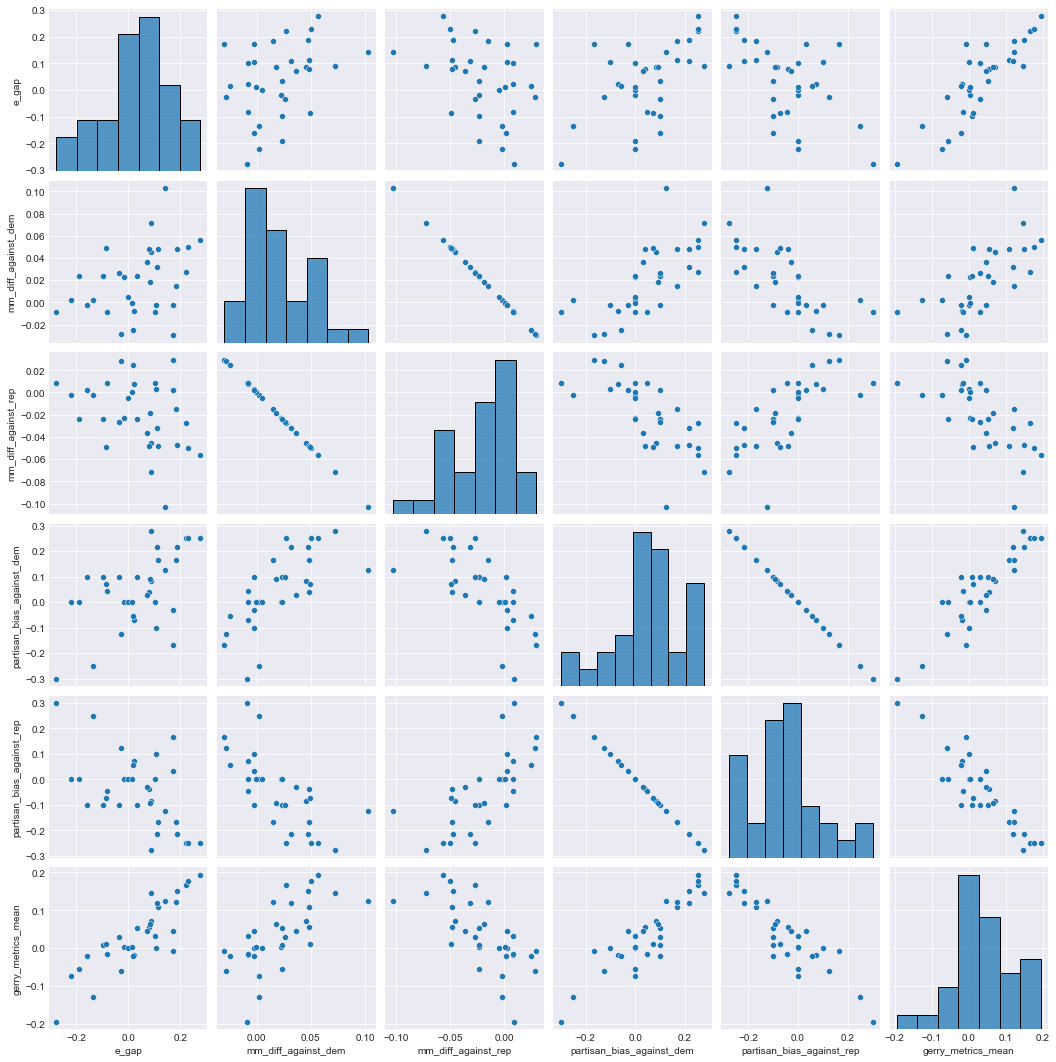

In [34]:
sns.pairplot(vote_counts_bystate_2018.iloc[:,5:])

<AxesSubplot:>

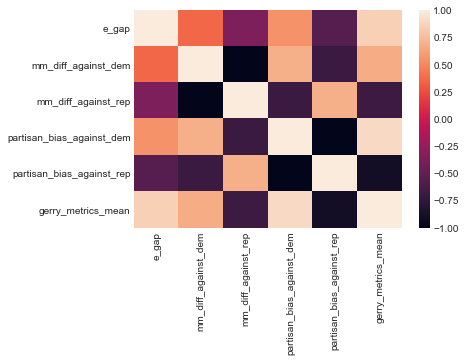

In [35]:
corr = vote_counts_bystate_2018.iloc[:,5:].corr()
sns.heatmap(corr)

In [36]:
no_redundant_metrics = ["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem", "gerry_metrics_mean"]


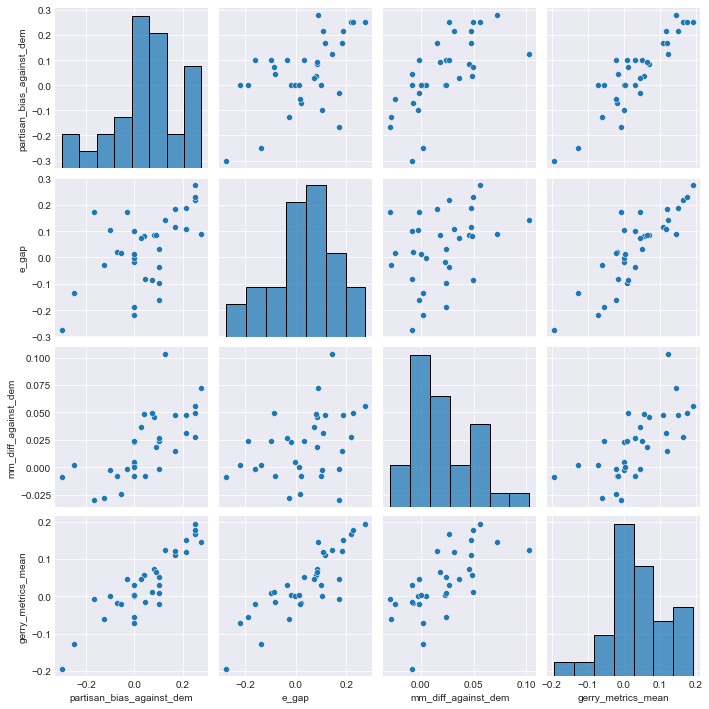

In [37]:
sns.pairplot(vote_counts_bystate_2018.loc[:,no_redundant_metrics])

<AxesSubplot:>

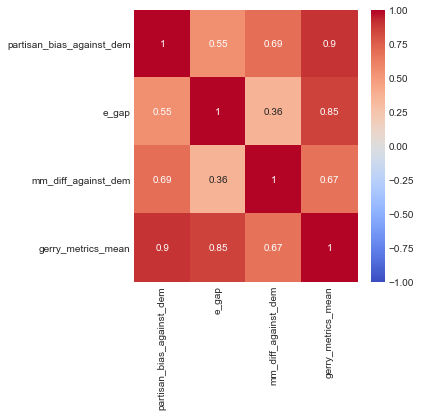

In [38]:
plt.figure(figsize=(5,5))
sns.heatmap(vote_counts_bystate_2018.loc[:,no_redundant_metrics].corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

In [39]:
vote_counts_bystate_2018.loc[:,no_redundant_metrics].corr()
corr

,e_gap,mm_diff_against_dem,mm_diff_against_rep,partisan_bias_against_dem,partisan_bias_against_rep,gerry_metrics_mean
e_gap,1.000000,0.363019,-0.363019,0.550188,-0.550188,0.853970
mm_diff_against_dem,0.363019,1.000000,-1.000000,0.693857,-0.693857,0.673235
mm_diff_against_rep,-0.363019,-1.000000,1.000000,-0.693857,0.693857,-0.673235
partisan_bias_against_dem,0.550188,0.693857,-0.693857,1.000000,-1.000000,0.898871
partisan_bias_against_rep,-0.550188,-0.693857,0.693857,-1.000000,1.000000,-0.898871
gerry_metrics_mean,0.853970,0.673235,-0.673235,0.898871,-0.898871,1.000000


# Plotting Distributions and Looking at Skewness 

By looking at the KDE plots for the gerrymandering scores we calculated for each state, we can see that the overall trend across the country is a negative skew. As we have seen from our election simulations and plotting the resulting distributions for them, we would expect our gerrymandering metrics to be normally distributed about the mean. Thus, this indicates that the country-wide trend is a gerrymander against democrats; i.e. the mode of all of our plots is observed to be above the mean.


In [40]:
# Skewness values
vote_counts_bystate_2018.loc[:,no_redundant_metrics].skew(axis=0)

partisan_bias_against_dem   -0.476103
e_gap                       -0.465034
mm_diff_against_dem          0.540920
gerry_metrics_mean          -0.268165
dtype: float64

<AxesSubplot:xlabel='partisan_bias_against_dem', ylabel='Density'>

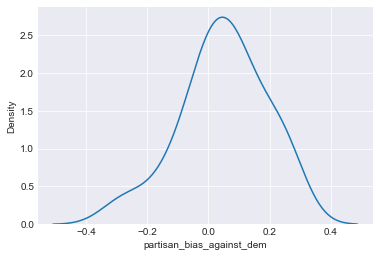

In [41]:
sns.kdeplot(vote_counts_bystate_2018["partisan_bias_against_dem"])

<AxesSubplot:xlabel='e_gap', ylabel='Count'>

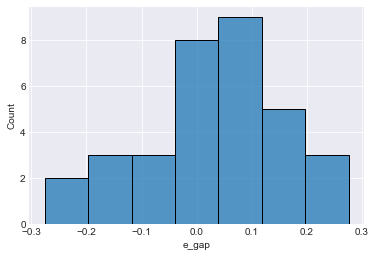

In [42]:
sns.histplot(vote_counts_bystate_2018["e_gap"])

<AxesSubplot:xlabel='partisan_bias_against_dem', ylabel='Count'>

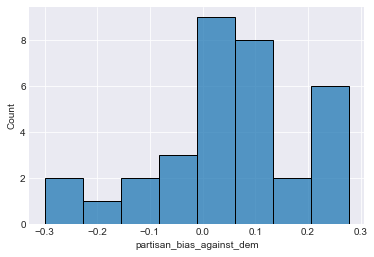

In [43]:
sns.histplot(vote_counts_bystate_2018["partisan_bias_against_dem"])

<AxesSubplot:xlabel='e_gap', ylabel='Density'>

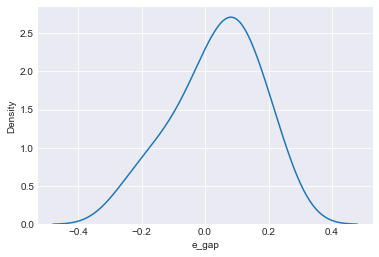

In [44]:
sns.kdeplot(vote_counts_bystate_2018["e_gap"])

<AxesSubplot:xlabel='mm_diff_against_dem', ylabel='Density'>

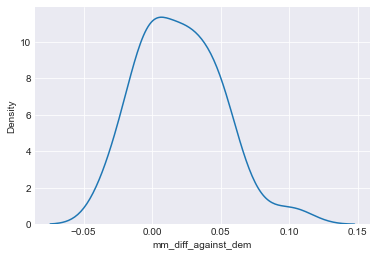

In [45]:
sns.kdeplot(vote_counts_bystate_2018["mm_diff_against_dem"])

<AxesSubplot:xlabel='mm_diff_against_dem', ylabel='Count'>

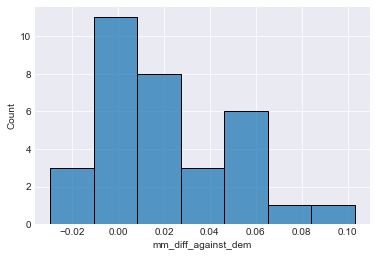

In [46]:
sns.histplot(vote_counts_bystate_2018["mm_diff_against_dem"])

<AxesSubplot:xlabel='gerry_metrics_mean', ylabel='Density'>

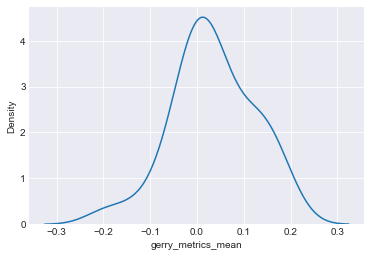

In [47]:
sns.kdeplot(vote_counts_bystate_2018["gerry_metrics_mean"])

<AxesSubplot:xlabel='gerry_metrics_mean', ylabel='Count'>

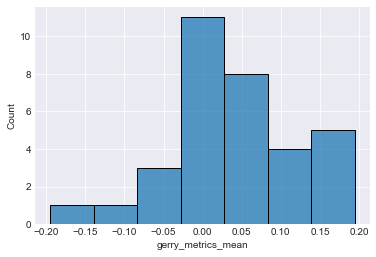

In [48]:
sns.histplot(vote_counts_bystate_2018["gerry_metrics_mean"])

## Examining Individual Metrics as Predictors of Gerrymandering (Binary Classification)

By using our derived gerrymandering scores as inputs to our machine learning models and predicting the labels, we can gain insight into which of our three metrics serve as predictors of our target labels, i.e. which of our three metrics contribute most to predicting gerrymandering from election results.


In [49]:
def hypothesis_test_95(num, num_districts):
    mean = aggregated_metrics_mean[num_districts]
    std = aggregated_metrics_std[num_districts]
    if num > mean + (2 * std) or num < mean - (2 * std):
        return True
    else:
        return False
def hypothesis_test_99(num, num_districts):
    mean = aggregated_metrics_mean[num_districts]
    std = aggregated_metrics_std[num_districts]
    if num > mean + 3 * std or num < mean - 2 * std:
        return True
    else:
        return False

In [50]:
vote_counts_bystate_over3 = vote_counts_bystate[vote_counts_bystate["num_districts"] > 3]

In [51]:
hypothesis_test_result = []
for i in range(len(vote_counts_bystate_over3)):
    num_districts = int(vote_counts_bystate_over3.iloc[i]["num_districts"])
    gerry_std = aggregated_metrics_std[num_districts]
    gerry_mean = aggregated_metrics_mean[num_districts]
    metrics_mean_3 = vote_counts_bystate_over3.iloc[i]["gerry_metrics_mean"]
    hypothesis_test_result.append(hypothesis_test_95(metrics_mean_3, num_districts))
    
vote_counts_bystate_over3["gerrymandered"] = hypothesis_test_result

C:\Users\dpale\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [52]:
vote_counts_bystate_over3[["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem", "gerrymandered"]].head()

partisan_bias_against_dem     e_gap  mm_diff_against_dem  \
year state                                                                   
1976 Alabama                       0.250000  0.262040             0.081262   
     Arizona                       0.000000  0.025202            -0.003855   
     California                   -0.071429  0.005700            -0.054207   
     Colorado                     -0.100000 -0.192256            -0.047309   
     Connecticut                  -0.166667 -0.149034            -0.051669   

                  gerrymandered  
year state                       
1976 Alabama               True  
     Arizona              False  
     California           False  
     Colorado             False  
     Connecticut           True

In [53]:
vote_counts_bystate_over3["gerrymandered"].value_counts()

False    537
True     134
Name: gerrymandered, dtype: int64

In [54]:
vote_counts_bystate_over3["mm_diff_against_dem"].describe()

count    671.000000
mean       0.004878
std        0.046378
min       -0.139046
25%       -0.027361
50%        0.003889
75%        0.035615
max        0.123647
Name: mm_diff_against_dem, dtype: float64

In [55]:
vote_counts_bystate_over3["e_gap"].describe()

count    671.000000
mean       0.016272
std        0.117055
min       -0.338080
25%       -0.060265
50%        0.015761
75%        0.094698
max        0.342052
Name: e_gap, dtype: float64

In [56]:
vote_counts_bystate_over3["partisan_bias_against_dem"].describe()

count    671.000000
mean      -0.001957
std        0.124609
min       -0.375000
25%       -0.088235
50%        0.000000
75%        0.077935
max        0.333333
Name: partisan_bias_against_dem, dtype: float64

In [57]:
from sklearn.metrics import roc_curve
def cv_scores(model, x, y, label, cv):
    model_cv_results = cross_validate(model, x, y, cv=cv, scoring=["accuracy"])
    model_cv_acc_mean = np.mean(model_cv_results["test_accuracy"])
    print(label)
    print("Accuracy: " + str(model_cv_acc_mean))
    
def tts_predict(model, x, y, label):
    """
        Holdout method used for plotting ROC curves
        on a single split
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:,1]
    y_predict = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=label)
    return y_test, y_prob, y_predict

def cv_scores_binary(model, x, y, label, cv):
    model_cv_results = cross_validate(model, x, y, cv=cv, scoring=["accuracy", "precision", "recall", "roc_auc"])
    model_cv_acc_mean = np.mean(model_cv_results["test_accuracy"])
    model_cv_precision_mean = np.mean(model_cv_results["test_precision"])
    model_cv_recall_mean = np.mean(model_cv_results["test_recall"])
    model_cv_auc_mean = np.mean(model_cv_results["test_roc_auc"])
    print(label)
    print("Accuracy: " + str(model_cv_acc_mean))
    print("Precision: " + str(model_cv_precision_mean))
    print("Recall: " + str(model_cv_recall_mean))
    print("AUC: " + str(model_cv_auc_mean))

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
sfold = StratifiedKFold(10, shuffle=True)
from sklearn.metrics import confusion_matrix
def predict_gerrymandering_metrics(model, label, x, y):
    # Baseline
    cv_scores_binary(model, x, y, "All Metrics", sfold)
    y_test, y_prob_, y_predict = tts_predict(model, x, y, "All Metrics")
    print(confusion_matrix(y_test, y_predict))
    
    # Individual metrics
    x = np.array(vote_counts_bystate_over3["partisan_bias_against_dem"]).reshape(-1, 1)
    cv_scores_binary(model, x, y, "Partisan Bias", sfold)
    y_test, y_prob_, y_predict = tts_predict(model, x, y, "Partisan Bias")

    x = np.array(vote_counts_bystate_over3["e_gap"]).reshape(-1, 1)
    cv_scores_binary(model, x, y, "Efficiency Gap", sfold)
    y_test, y_prob_, y_predict = tts_predict(model, x, y, "Efficiency Gap")

    x = np.array(vote_counts_bystate_over3["mm_diff_against_dem"]).reshape(-1, 1)
    cv_scores_binary(model, x, y, "Mean-Median Difference", sfold)
    y_test, y_prob_, y_predict = tts_predict(model, x, y, "Mean-Median Difference")


    plt.plot([0, 1], [0, 1], linestyle="dotted")
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(8,8)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    fig.suptitle(label, fontsize=15)


All Metrics
Accuracy: 0.9210491659350307
Precision: 0.8249096736596737
Recall: 0.7758241758241758
AUC: 0.9672689120802328
[[130   5]
 [  8  25]]
Partisan Bias
Accuracy: 0.8465978928884986
Precision: 0.6773629148629148
Recall: 0.5296703296703298
AUC: 0.8929643644266287
Efficiency Gap
Accuracy: 0.8151887620719929
Precision: 0.6202777777777777
Recall: 0.25384615384615383
AUC: 0.805242434016019
Mean-Median Difference
Accuracy: 0.8077260755048288
Precision: 0.55
Recall: 0.2532967032967033
AUC: 0.717763072008355


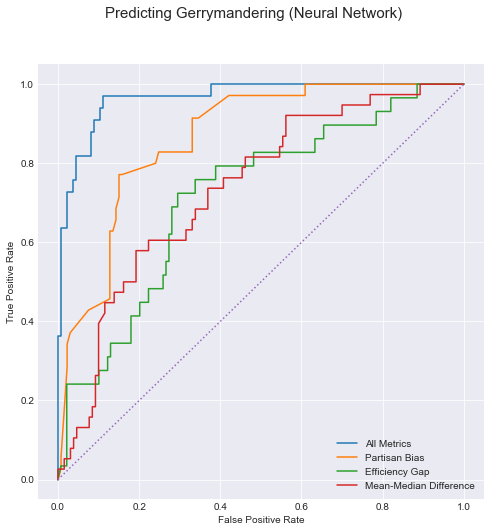

In [59]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
scaler = MinMaxScaler()
gerry_metric_names = ["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem"]
x = vote_counts_bystate_over3[gerry_metric_names]
x = scaler.fit_transform(x)
y = np.array(vote_counts_bystate_over3["gerrymandered"])
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=5000, hidden_layer_sizes=(6, 12, 6), random_state=1)
predict_gerrymandering_metrics(nn,"Predicting Gerrymandering (Neural Network)",x,y)

All Metrics
Accuracy: 0.9240122914837576
Precision: 0.8983022533022533
Recall: 0.7010989010989012
AUC: 0.9692747329539781
[[131   4]
 [ 10  23]]
Partisan Bias
Accuracy: 0.8777655838454784
Precision: 0.7737848262848263
Recall: 0.5494505494505495
AUC: 0.8885966933136744
Efficiency Gap
Accuracy: 0.7585601404741
Precision: 0.39534565108094527
Recall: 0.356043956043956
AUC: 0.7108424332480936
Mean-Median Difference
Accuracy: 0.7138279192273924
Precision: 0.281890756302521
Recall: 0.2857142857142857
AUC: 0.6325631042612174


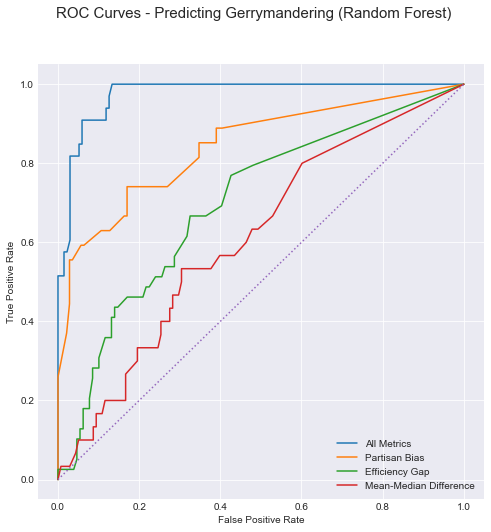

In [60]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
scaler = MinMaxScaler((-1,1))
gerry_metric_names = ["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem"]
x = vote_counts_bystate_over3[gerry_metric_names]
x = scaler.fit_transform(x)
y = np.array(vote_counts_bystate_over3["gerrymandered"])
rf_model = RandomForestClassifier()
predict_gerrymandering_metrics(rf_model,"ROC Curves - Predicting Gerrymandering (Random Forest)",x,y)

All Metrics
Accuracy: 0.9254828797190516
Precision: 0.8759274059274059
Recall: 0.7406593406593406
AUC: 0.9698495250382043
[[125   5]
 [  9  29]]
Partisan Bias
Accuracy: 0.8538849868305531
Precision: 0.78
Recall: 0.43296703296703304
AUC: 0.8372114520699426
Efficiency Gap
Accuracy: 0.8107111501316945
Precision: 0.6876984126984127
Recall: 0.18681318681318682
AUC: 0.688361708173029


C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dpale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean-Median Difference
Accuracy: 0.7987928007023706
Precision: 0.40166666666666667
Recall: 0.12142857142857144
AUC: 0.6812451524715676


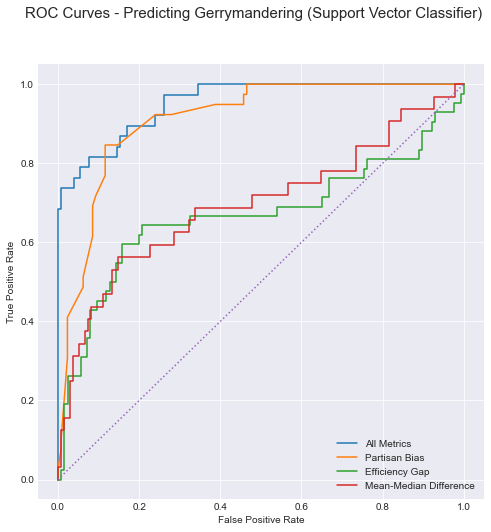

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
scaler = MinMaxScaler()
gerry_metric_names = ["partisan_bias_against_dem", "e_gap", "mm_diff_against_dem"]
x = vote_counts_bystate_over3[gerry_metric_names]
x = scaler.fit_transform(x)
y = np.array(vote_counts_bystate_over3["gerrymandered"])
svc = SVC(random_state = 45, probability = True)
predict_gerrymandering_metrics(svc,"ROC Curves - Predicting Gerrymandering (Support Vector Classifier)",x,y)


In [62]:
vote_counts_bystate

dem_votes  rep_votes  num_districts  wasted_democrat  \
year state                                                                 
1976 Alabama         336068.0   314970.0              4         248056.5   
     Alaska           34194.0    83722.0              1          34194.0   
     Arizona         355747.0   340478.0              4         182827.5   
     Arkansas        260997.0    75384.0              2          92804.5   
     California     4061169.0  3220418.0             42        1841126.5   
...                       ...        ...            ...              ...   
2018 Virginia       1668446.0  1408701.0             10         714841.0   
     Washington     1437839.0  1048712.0              8         621013.0   
     West Virginia   234568.0   337146.0              3         234568.0   
     Wisconsin      1058376.0  1172964.0              7         768151.0   
     Wyoming          59903.0   127963.0              1          59903.0   

                    wasted_republican     e_gap  mm_diff_against_dem  \
year state                                                             
1976 Alabama                  77458.5  0.262040             0.081262   
     Alaska                   24763.0  0.079981             0.000000   
     Arizona                 165281.0  0.025202            -0.003855   
     Arkansas                 75384.0  0.051788             0.000000   
     California             1799625.0  0.005700            -0.054207   
...                               ...       ...                  ...   
2018 Virginia                823722.5 -0.035384             0.026638   
     Washington              622254.5 -0.000499             0.004619   
     West Virginia            51286.0  0.320583            -0.024979   
     Wisconsin               347512.0  0.188514             0.047635   
     Wyoming                  34029.0  0.137726             0.000000   

                    mm_diff_against_rep  partisan_bias_against_dem  \
year state                                                           
1976 Alabama                  -0.081262                   0.250000   
     Alaska                    0.000000                  -0.500000   
     Arizona                   0.003855                   0.000000   
     Arkansas                  0.000000                   0.000000   
     California                0.054207                  -0.071429   
...                                 ...                        ...   
2018 Virginia                 -0.026638                   0.100000   
     Washington               -0.004619                   0.000000   
     West Virginia             0.024979                  -0.166667   
     Wisconsin                -0.047635                   0.214286   
     Wyoming                   0.000000                  -0.500000   

                    partisan_bias_against_rep  gerry_metrics_mean  
year state                                                         
1976 Alabama                        -0.250000            0.197767  
     Alaska                         -0.500000           -0.140006  
     Arizona                         0.000000            0.007116  
     Arkansas                        0.000000            0.017263  
     California                      0.071429           -0.039979  
...                                       ...                 ...  
2018 Virginia                       -0.100000            0.030418  
     Washington                      0.000000            0.001373  
     West Virginia                   0.166667            0.042979  
     Wisconsin                      -0.214286            0.150145  
     Wyoming                        -0.500000           -0.120758  

[1074 rows x 11 columns]

In [ ]:
vote_